# Crop Yield Prediction – Final Model Pipeline (Rev6)

## 1. Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import shap

np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')
print("All libraries loaded.")

C:\Users\PavinP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries loaded.


## 2. Model Selection Menu

In [ ]:
RUN_MODELS = {
    'LR': True,   # Baseline Linear Regression
    'RF': True,   # Random Forest
    'XGB': True,  # XGBoost
    'LSTM': True, # LSTM
    'CNN': True   # CNN
}

RUN_OPTUNA = True

## 3. Load & Preprocess Data

In [ ]:
try:
    df = pd.read_csv("prediction yield_new2.csv")
    print(f"Loaded: {df.shape}")
except:
    raise FileNotFoundError("Run EDA first!")

TARGET = 'hg/ha_yield'
TIME_COL = 'Year'
CAT_COLS = ['Area', 'Item']
NUMERIC_COLS = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'fertilizer_kg/ha', 'solar_radiation_MJ/m2-day']

# De-trend per group
df = df.sort_values(CAT_COLS + [TIME_COL])
df['yield_detrended'] = df.groupby(CAT_COLS)[TARGET].transform(detrend)
df['yield_trend'] = df[TARGET] - df['yield_detrended']
TARGET_DET = 'yield_detrended'

# Lags for ML
LAG_COLS = [TARGET_DET] + NUMERIC_COLS
for col in LAG_COLS:
    for lag in [1, 2]:
        df[f'{col}_lag{lag}'] = df.groupby(CAT_COLS)[col].shift(lag)
df_ml = df.dropna().copy()

# Split
TRAIN_END = 2007
VAL_END = 2010
train_df = df_ml[df_ml[TIME_COL] <= TRAIN_END].copy()
val_df = df_ml[(df_ml[TIME_COL] > TRAIN_END) & (df_ml[TIME_COL] <= VAL_END)].copy()
test_df = df_ml[df_ml[TIME_COL] > VAL_END].copy()

# Encode
le_area = LabelEncoder().fit(df_ml['Area'])
le_item = LabelEncoder().fit(df_ml['Item'])
for d in [train_df, val_df, test_df]:
    d['Area_Encoded'] = le_area.transform(d['Area'])
    d['Item_Encoded'] = le_item.transform(d['Item'])

# Scale
lagged_cols = [c for c in df_ml.columns if '_lag' in c]
scale_cols = NUMERIC_COLS + lagged_cols
scaler = StandardScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
val_df[scale_cols] = scaler.transform(val_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le_area, 'le_area.joblib')
joblib.dump(le_item, 'le_item.joblib')

N_AREAS = len(le_area.classes_)
N_ITEMS = len(le_item.classes_)

Loaded: (25932, 9)


## 4. Prepare Inputs

In [ ]:
# ML
ML_FEATS = NUMERIC_COLS + lagged_cols + ['Area_Encoded', 'Item_Encoded']
X_train_ml = train_df[ML_FEATS]
y_train_ml = train_df[TARGET_DET]
X_val_ml = val_df[ML_FEATS]
y_val_ml = val_df[TARGET_DET]
X_test_ml = test_df[ML_FEATS]
y_test_ml = test_df[TARGET_DET]

# DL Sequences
LOOKBACK = 5
DL_FEATS = NUMERIC_COLS + ['Area_Encoded', 'Item_Encoded']

def create_sequences(data, lookback, feats, target):
    X, y = [], []
    for _, group in data.groupby(CAT_COLS):
        if len(group) < lookback:
            continue
        gf = group[feats].values
        gt = group[target].values
        for i in range(len(group) - lookback + 1):
            X.append(gf[i:i+lookback])
            y.append(gt[i+lookback-1])
    return np.array(X), np.array(y)

scaler_dl = StandardScaler()
train_df_dl = df[df[TIME_COL] <= TRAIN_END].copy()
val_df_dl = df[(df[TIME_COL] > TRAIN_END) & (df[TIME_COL] <= VAL_END)].copy()
test_df_dl = df[df[TIME_COL] > VAL_END].copy()
train_df_dl['Area_Encoded'] = le_area.transform(train_df_dl['Area'])
train_df_dl['Item_Encoded'] = le_item.transform(train_df_dl['Item'])
val_df_dl['Area_Encoded'] = le_area.transform(val_df_dl['Area'])
val_df_dl['Item_Encoded'] = le_item.transform(val_df_dl['Item'])
test_df_dl['Area_Encoded'] = le_area.transform(test_df_dl['Area'])
test_df_dl['Item_Encoded'] = le_item.transform(test_df_dl['Item'])
train_df_dl[NUMERIC_COLS] = scaler_dl.fit_transform(train_df_dl[NUMERIC_COLS])
val_df_dl[NUMERIC_COLS] = scaler_dl.transform(val_df_dl[NUMERIC_COLS])
test_df_dl[NUMERIC_COLS] = scaler_dl.transform(test_df_dl[NUMERIC_COLS])

X_train_seq, y_train_seq = create_sequences(train_df_dl, LOOKBACK, DL_FEATS, TARGET_DET)
X_val_seq, y_val_seq = create_sequences(val_df_dl, LOOKBACK, DL_FEATS, TARGET_DET)
X_test_seq, y_test_seq = create_sequences(test_df_dl, LOOKBACK, DL_FEATS, TARGET_DET)

def split_dl(X):
    return [
        torch.tensor(X[..., :-2], dtype=torch.float32),
        torch.tensor(X[..., -2], dtype=torch.long),
        torch.tensor(X[..., -1], dtype=torch.long)
    ]

X_train_dl = split_dl(X_train_seq)
X_val_dl = split_dl(X_val_seq)
X_test_dl = split_dl(X_test_seq)

y_train_t = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1)

## 5. Metrics

In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / (y_true + 1e-8)) ** 2)) * 100

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

## 6. Optuna Objectives

In [ ]:
def objective_lr(trial):
    # No hyperparameters to tune for Linear Regression
    return 0

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_ml):
        model.fit(X_train_ml.iloc[train_idx], y_train_ml.iloc[train_idx])
        pred = model.predict(X_train_ml.iloc[val_idx])
        scores.append(rmspe(y_train_ml.iloc[val_idx], pred))
    return np.mean(scores)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }
    model = xgb.XGBRegressor(random_state=42, **params)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_ml):
        model.fit(X_train_ml.iloc[train_idx], y_train_ml.iloc[train_idx])
        pred = model.predict(X_train_ml.iloc[val_idx])
        scores.append(rmspe(y_train_ml.iloc[val_idx], pred))
    return np.mean(scores)

class LSTMModel(nn.Module):
    def __init__(self, n_areas, n_items, lstm_units, dense_units, dropout):
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.lstm = nn.LSTM(len(NUMERIC_COLS) + 10 + 5, lstm_units, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        e_area = self.embed_area(area)
        e_item = self.embed_item(item)
        x = torch.cat([num, e_area, e_item], dim=-1)
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1])
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

def train_dl(model, opt, loss_fn, train_loader, val_loader, epochs=100, patience=10, is_final=False):
    best = float('inf')
    wait = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x1, x2, x3, y in train_loader:
            opt.zero_grad()
            pred = model(x1, x2, x3)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        model.eval()
        with torch.no_grad():
            val_inputs = [x.to(next(model.parameters()).device) for x in val_loader.dataset.tensors[:3]]
            val_y = val_loader.dataset.tensors[3]
            val_pred = model(*val_inputs)
            val_mse = loss_fn(val_pred, val_y).item()
            val_rmspe = rmspe(val_y.numpy().flatten(), val_pred.numpy().flatten())
        val_losses.append(val_mse)
        if val_rmspe < best:
            best = val_rmspe
            wait = 0
            if is_final:
                torch.save(model.state_dict(), f'model_{{model.__class__.__name__}}.pth')
        else:
            wait += 1
            if wait >= patience:
                break
    return train_losses, val_losses

def objective_lstm(trial):
    params = {
        'lstm_units': trial.suggest_categorical('lstm_units', [64, 128]),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    }
    lr = params.pop('lr')
    model = LSTMModel(N_AREAS, N_ITEMS, **params)
    opt = optim.Adam(model.parameters(), lr=lr)
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    _, val_losses = train_dl(model, opt, nn.MSELoss(), train_loader, val_loader)
    return val_losses[-1]

class CNNModel(nn.Module):
    def __init__(self, n_areas, n_items, filters, kernel, dense_units): 
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.conv = nn.Conv1d(len(NUMERIC_COLS) + 10 + 5, filters, kernel)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(filters, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        e_area = self.embed_area(area)
        e_item = self.embed_item(item)
        x = torch.cat([num, e_area, e_item], dim=-1).transpose(1, 2)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def objective_cnn(trial):
    params = {
        'filters': trial.suggest_categorical('filters', [64, 128]),
        'kernel': trial.suggest_categorical('kernel', [2, 3]),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64]),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    }
    lr = params.pop('lr')
    model = CNNModel(N_AREAS, N_ITEMS, **params)
    opt = optim.Adam(model.parameters(), lr=lr)
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    _, val_losses = train_dl(model, opt, nn.MSELoss(), train_loader, val_loader)
    return val_losses[-1]

## 7. Run Optuna

In [ ]:
if os.path.exists('best_params_optuna.joblib'):
    best_params = joblib.load('best_params_optuna.joblib')
else:
    best_params = {}

if RUN_OPTUNA:
    objectives = {
        'LR': objective_lr,
        'RF': objective_rf,
        'XGB': objective_xgb,
        'LSTM': objective_lstm,
        'CNN': objective_cnn
    }
    for name, run in RUN_MODELS.items():
        if run:
            print(f'--- Tuning {name} ---')
            study = optuna.create_study(direction='minimize')
            n_trials = 50 if name in ['RF', 'XGB'] else 30
            if name == 'LR':
                n_trials = 1
            study.optimize(objectives[name], n_trials=n_trials, show_progress_bar=True)
            best_params[name] = study.best_params
            joblib.dump(best_params, 'best_params_optuna.joblib') # Save after each study
            print(f'Best params for {name}: {study.best_params}')
else:
    print('Skipping Optuna tuning.')

[I 2025-11-16 20:52:22,463] A new study created in memory with name: no-name-4375faa5-8eca-4fa1-9384-ed947e44679c


--- Tuning LR ---


Best trial: 0. Best value: 0: 100%|██████████| 1/1 [00:00<00:00, 495.25it/s]
[I 2025-11-16 20:52:22,473] A new study created in memory with name: no-name-fe59e3ca-a1be-4956-89e1-f2992a847c6e


[I 2025-11-16 20:52:22,468] Trial 0 finished with value: 0.0 and parameters: {}. Best is trial 0 with value: 0.0.
Best params for LR: {}
--- Tuning RF ---


Best trial: 0. Best value: 3066.22:   2%|▏         | 1/50 [00:10<08:18, 10.18s/it]

[I 2025-11-16 20:52:32,649] Trial 0 finished with value: 3066.217430315532 and parameters: {'n_estimators': 248, 'max_depth': 22, 'min_samples_leaf': 1, 'max_features': 0.5248201827031374}. Best is trial 0 with value: 3066.217430315532.


Best trial: 1. Best value: 1736.13:   4%|▍         | 2/50 [00:13<05:09,  6.44s/it]

[I 2025-11-16 20:52:36,472] Trial 1 finished with value: 1736.1305560152002 and parameters: {'n_estimators': 60, 'max_depth': 19, 'min_samples_leaf': 4, 'max_features': 0.9915857175435303}. Best is trial 1 with value: 1736.1305560152002.


Best trial: 2. Best value: 1573.75:   6%|▌         | 3/50 [00:22<05:37,  7.17s/it]

[I 2025-11-16 20:52:44,516] Trial 2 finished with value: 1573.7464969430694 and parameters: {'n_estimators': 177, 'max_depth': 19, 'min_samples_leaf': 3, 'max_features': 0.6910445867152606}. Best is trial 2 with value: 1573.7464969430694.


Best trial: 3. Best value: 1442.7:   8%|▊         | 4/50 [00:28<05:23,  7.03s/it] 

[I 2025-11-16 20:52:51,331] Trial 3 finished with value: 1442.6977845849265 and parameters: {'n_estimators': 205, 'max_depth': 14, 'min_samples_leaf': 10, 'max_features': 0.6924577163248717}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  10%|█         | 5/50 [00:51<09:28, 12.62s/it]

[I 2025-11-16 20:53:13,869] Trial 4 finished with value: 1561.3975281297626 and parameters: {'n_estimators': 377, 'max_depth': 20, 'min_samples_leaf': 5, 'max_features': 0.9452680193010287}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  12%|█▏        | 6/50 [00:59<08:01, 10.95s/it]

[I 2025-11-16 20:53:21,585] Trial 5 finished with value: 1548.4799137706784 and parameters: {'n_estimators': 135, 'max_depth': 16, 'min_samples_leaf': 5, 'max_features': 0.9458152554610522}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  14%|█▍        | 7/50 [01:06<07:04,  9.87s/it]

[I 2025-11-16 20:53:29,225] Trial 6 finished with value: 1561.884954757585 and parameters: {'n_estimators': 229, 'max_depth': 11, 'min_samples_leaf': 10, 'max_features': 0.8148826785771918}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  16%|█▌        | 8/50 [01:15<06:44,  9.63s/it]

[I 2025-11-16 20:53:38,350] Trial 7 finished with value: 1552.8977320128813 and parameters: {'n_estimators': 254, 'max_depth': 12, 'min_samples_leaf': 10, 'max_features': 0.8077540174038533}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  18%|█▊        | 9/50 [01:19<05:18,  7.78s/it]

[I 2025-11-16 20:53:42,052] Trial 8 finished with value: 1630.6973698048005 and parameters: {'n_estimators': 110, 'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 0.9248515328845169}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  20%|██        | 10/50 [01:28<05:20,  8.01s/it]

[I 2025-11-16 20:53:50,564] Trial 9 finished with value: 1559.7357068741242 and parameters: {'n_estimators': 280, 'max_depth': 17, 'min_samples_leaf': 7, 'max_features': 0.578306355171849}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  22%|██▏       | 11/50 [01:42<06:24,  9.85s/it]

[I 2025-11-16 20:54:04,583] Trial 10 finished with value: 1765.5900794354125 and parameters: {'n_estimators': 338, 'max_depth': 30, 'min_samples_leaf': 8, 'max_features': 0.6616939460865806}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  24%|██▍       | 12/50 [01:49<05:47,  9.14s/it]

[I 2025-11-16 20:54:12,110] Trial 11 finished with value: 1524.495644482601 and parameters: {'n_estimators': 135, 'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.8485691523879111}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  26%|██▌       | 13/50 [01:53<04:39,  7.54s/it]

[I 2025-11-16 20:54:15,975] Trial 12 finished with value: 1740.4487076284445 and parameters: {'n_estimators': 180, 'max_depth': 5, 'min_samples_leaf': 7, 'max_features': 0.8247303698017069}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  28%|██▊       | 14/50 [02:01<04:38,  7.74s/it]

[I 2025-11-16 20:54:24,161] Trial 13 finished with value: 1529.888783059213 and parameters: {'n_estimators': 155, 'max_depth': 25, 'min_samples_leaf': 9, 'max_features': 0.726225735732399}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  30%|███       | 15/50 [02:05<03:45,  6.44s/it]

[I 2025-11-16 20:54:27,607] Trial 14 finished with value: 1888.0629949879526 and parameters: {'n_estimators': 82, 'max_depth': 14, 'min_samples_leaf': 2, 'max_features': 0.625178386301253}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  32%|███▏      | 16/50 [02:10<03:32,  6.24s/it]

[I 2025-11-16 20:54:33,371] Trial 15 finished with value: 1580.425023621863 and parameters: {'n_estimators': 198, 'max_depth': 8, 'min_samples_leaf': 6, 'max_features': 0.7651631052110803}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  34%|███▍      | 17/50 [02:30<05:41, 10.35s/it]

[I 2025-11-16 20:54:53,283] Trial 16 finished with value: 1564.5508269026711 and parameters: {'n_estimators': 315, 'max_depth': 14, 'min_samples_leaf': 9, 'max_features': 0.9014911926513449}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  36%|███▌      | 18/50 [02:38<05:02,  9.45s/it]

[I 2025-11-16 20:55:00,636] Trial 17 finished with value: 1648.001609611242 and parameters: {'n_estimators': 116, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.8661866289933524}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  38%|███▊      | 19/50 [02:41<03:56,  7.62s/it]

[I 2025-11-16 20:55:04,005] Trial 18 finished with value: 1694.5674061182413 and parameters: {'n_estimators': 196, 'max_depth': 5, 'min_samples_leaf': 4, 'max_features': 0.7606920555449863}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  40%|████      | 20/50 [02:50<04:00,  8.01s/it]

[I 2025-11-16 20:55:12,927] Trial 19 finished with value: 1464.3531429802517 and parameters: {'n_estimators': 290, 'max_depth': 14, 'min_samples_leaf': 8, 'max_features': 0.6177185688940141}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  42%|████▏     | 21/50 [02:58<03:49,  7.91s/it]

[I 2025-11-16 20:55:20,608] Trial 20 finished with value: 1630.0495192459032 and parameters: {'n_estimators': 295, 'max_depth': 10, 'min_samples_leaf': 9, 'max_features': 0.6084181185791766}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  44%|████▍     | 22/50 [03:10<04:15,  9.12s/it]

[I 2025-11-16 20:55:32,546] Trial 21 finished with value: 1617.1370912831921 and parameters: {'n_estimators': 373, 'max_depth': 14, 'min_samples_leaf': 7, 'max_features': 0.5360701326935452}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  46%|████▌     | 23/50 [03:18<04:02,  8.98s/it]

[I 2025-11-16 20:55:41,196] Trial 22 finished with value: 1527.7862301501268 and parameters: {'n_estimators': 219, 'max_depth': 16, 'min_samples_leaf': 8, 'max_features': 0.6825101893592096}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  48%|████▊     | 24/50 [03:27<03:50,  8.87s/it]

[I 2025-11-16 20:55:49,801] Trial 23 finished with value: 1589.5057541031642 and parameters: {'n_estimators': 268, 'max_depth': 13, 'min_samples_leaf': 9, 'max_features': 0.6407808351290181}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  50%|█████     | 25/50 [03:30<02:56,  7.04s/it]

[I 2025-11-16 20:55:52,588] Trial 24 finished with value: 1632.6127368106695 and parameters: {'n_estimators': 153, 'max_depth': 8, 'min_samples_leaf': 10, 'max_features': 0.5646972468546166}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 3. Best value: 1442.7:  52%|█████▏    | 26/50 [03:44<03:41,  9.22s/it]

[I 2025-11-16 20:56:06,891] Trial 25 finished with value: 1573.7225256723564 and parameters: {'n_estimators': 331, 'max_depth': 15, 'min_samples_leaf': 8, 'max_features': 0.737854408645237}. Best is trial 3 with value: 1442.6977845849265.


Best trial: 26. Best value: 1430.44:  54%|█████▍    | 27/50 [03:54<03:37,  9.46s/it]

[I 2025-11-16 20:56:16,922] Trial 26 finished with value: 1430.4365237209936 and parameters: {'n_estimators': 231, 'max_depth': 12, 'min_samples_leaf': 6, 'max_features': 0.8712758184394289}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  56%|█████▌    | 28/50 [04:02<03:16,  8.92s/it]

[I 2025-11-16 20:56:24,563] Trial 27 finished with value: 1489.836589622822 and parameters: {'n_estimators': 231, 'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.6977042923270054}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  58%|█████▊    | 29/50 [04:10<03:05,  8.84s/it]

[I 2025-11-16 20:56:33,238] Trial 28 finished with value: 1693.329785349874 and parameters: {'n_estimators': 302, 'max_depth': 18, 'min_samples_leaf': 10, 'max_features': 0.5002301683565633}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  60%|██████    | 30/50 [04:20<03:00,  9.03s/it]

[I 2025-11-16 20:56:42,687] Trial 29 finished with value: 1594.1720786783524 and parameters: {'n_estimators': 249, 'max_depth': 22, 'min_samples_leaf': 9, 'max_features': 0.5976258275468763}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  62%|██████▏   | 31/50 [04:31<03:01,  9.56s/it]

[I 2025-11-16 20:56:53,493] Trial 30 finished with value: 1674.5304855067418 and parameters: {'n_estimators': 208, 'max_depth': 21, 'min_samples_leaf': 5, 'max_features': 0.7853543679878151}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  64%|██████▍   | 32/50 [04:38<02:43,  9.06s/it]

[I 2025-11-16 20:57:01,404] Trial 31 finished with value: 1486.1257683185845 and parameters: {'n_estimators': 224, 'max_depth': 11, 'min_samples_leaf': 7, 'max_features': 0.7020484621333454}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  66%|██████▌   | 33/50 [04:48<02:39,  9.36s/it]

[I 2025-11-16 20:57:11,465] Trial 32 finished with value: 2027.6715129783383 and parameters: {'n_estimators': 267, 'max_depth': 12, 'min_samples_leaf': 1, 'max_features': 0.7205143244041619}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  68%|██████▊   | 34/50 [04:55<02:13,  8.37s/it]

[I 2025-11-16 20:57:17,516] Trial 33 finished with value: 1461.8383422391794 and parameters: {'n_estimators': 237, 'max_depth': 8, 'min_samples_leaf': 6, 'max_features': 0.6551902288226721}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  70%|███████   | 35/50 [05:00<01:53,  7.58s/it]

[I 2025-11-16 20:57:23,248] Trial 34 finished with value: 1559.4965843277805 and parameters: {'n_estimators': 240, 'max_depth': 7, 'min_samples_leaf': 4, 'max_features': 0.6529415423212204}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  72%|███████▏  | 36/50 [05:06<01:38,  7.02s/it]

[I 2025-11-16 20:57:28,958] Trial 35 finished with value: 1679.7926919104816 and parameters: {'n_estimators': 176, 'max_depth': 7, 'min_samples_leaf': 3, 'max_features': 0.989119157084092}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  74%|███████▍  | 37/50 [05:13<01:29,  6.91s/it]

[I 2025-11-16 20:57:35,610] Trial 36 finished with value: 1484.857709350907 and parameters: {'n_estimators': 284, 'max_depth': 9, 'min_samples_leaf': 5, 'max_features': 0.5544073700892125}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  76%|███████▌  | 38/50 [05:26<01:47,  8.95s/it]

[I 2025-11-16 20:57:49,329] Trial 37 finished with value: 1530.6075457937563 and parameters: {'n_estimators': 353, 'max_depth': 16, 'min_samples_leaf': 6, 'max_features': 0.6702652654787755}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  78%|███████▊  | 39/50 [05:36<01:39,  9.01s/it]

[I 2025-11-16 20:57:58,471] Trial 38 finished with value: 1671.5304605270394 and parameters: {'n_estimators': 257, 'max_depth': 19, 'min_samples_leaf': 8, 'max_features': 0.623738473977101}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  80%|████████  | 40/50 [05:42<01:21,  8.14s/it]

[I 2025-11-16 20:58:04,576] Trial 39 finished with value: 1536.5787664365228 and parameters: {'n_estimators': 184, 'max_depth': 12, 'min_samples_leaf': 3, 'max_features': 0.5963888497339085}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  82%|████████▏ | 41/50 [05:53<01:22,  9.13s/it]

[I 2025-11-16 20:58:16,031] Trial 40 finished with value: 1463.0741739348339 and parameters: {'n_estimators': 400, 'max_depth': 9, 'min_samples_leaf': 5, 'max_features': 0.7815748441588806}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  84%|████████▍ | 42/50 [06:06<01:22, 10.33s/it]

[I 2025-11-16 20:58:29,139] Trial 41 finished with value: 1576.5976157304754 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.7834683168619977}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  86%|████████▌ | 43/50 [06:15<01:08,  9.76s/it]

[I 2025-11-16 20:58:37,593] Trial 42 finished with value: 1632.102570885361 and parameters: {'n_estimators': 399, 'max_depth': 6, 'min_samples_leaf': 4, 'max_features': 0.8945426326914461}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  88%|████████▊ | 44/50 [06:25<00:59,  9.87s/it]

[I 2025-11-16 20:58:47,707] Trial 43 finished with value: 1588.7450948167475 and parameters: {'n_estimators': 318, 'max_depth': 10, 'min_samples_leaf': 6, 'max_features': 0.8348854944821505}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  90%|█████████ | 45/50 [06:38<00:53, 10.75s/it]

[I 2025-11-16 20:59:00,513] Trial 44 finished with value: 1616.922383176281 and parameters: {'n_estimators': 365, 'max_depth': 13, 'min_samples_leaf': 5, 'max_features': 0.7139542343029807}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  92%|█████████▏| 46/50 [06:45<00:38,  9.71s/it]

[I 2025-11-16 20:59:07,791] Trial 45 finished with value: 1510.745036825828 and parameters: {'n_estimators': 215, 'max_depth': 9, 'min_samples_leaf': 7, 'max_features': 0.8645955716353341}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  94%|█████████▍| 47/50 [06:58<00:32, 10.69s/it]

[I 2025-11-16 20:59:20,786] Trial 46 finished with value: 1563.4146754001395 and parameters: {'n_estimators': 239, 'max_depth': 18, 'min_samples_leaf': 6, 'max_features': 0.8011905423617243}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  96%|█████████▌| 48/50 [07:04<00:18,  9.39s/it]

[I 2025-11-16 20:59:27,130] Trial 47 finished with value: 1480.2469221262647 and parameters: {'n_estimators': 166, 'max_depth': 13, 'min_samples_leaf': 8, 'max_features': 0.6780526711216732}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44:  98%|█████████▊| 49/50 [07:18<00:10, 10.73s/it]

[I 2025-11-16 20:59:40,987] Trial 48 finished with value: 1632.9588015756556 and parameters: {'n_estimators': 205, 'max_depth': 29, 'min_samples_leaf': 10, 'max_features': 0.9602612939030267}. Best is trial 26 with value: 1430.4365237209936.


Best trial: 26. Best value: 1430.44: 100%|██████████| 50/50 [07:21<00:00,  8.82s/it]
[I 2025-11-16 20:59:43,542] A new study created in memory with name: no-name-29cb1d1f-6abd-4db0-8641-0b53950653d5


[I 2025-11-16 20:59:43,542] Trial 49 finished with value: 1633.1864626255933 and parameters: {'n_estimators': 51, 'max_depth': 16, 'min_samples_leaf': 4, 'max_features': 0.7501497125031319}. Best is trial 26 with value: 1430.4365237209936.
Best params for RF: {'n_estimators': 231, 'max_depth': 12, 'min_samples_leaf': 6, 'max_features': 0.8712758184394289}
--- Tuning XGB ---


Best trial: 0. Best value: 3329.21:   2%|▏         | 1/50 [00:02<01:40,  2.06s/it]

[I 2025-11-16 20:59:45,609] Trial 0 finished with value: 3329.2061925479466 and parameters: {'n_estimators': 128, 'max_depth': 9, 'learning_rate': 0.038509224459255434, 'subsample': 0.7819787597417733, 'colsample_bytree': 0.6175254881338113, 'gamma': 1.2771180819718408}. Best is trial 0 with value: 3329.2061925479466.


Best trial: 1. Best value: 1285.01:   4%|▍         | 2/50 [00:02<00:52,  1.10s/it]

[I 2025-11-16 20:59:46,036] Trial 1 finished with value: 1285.012514846375 and parameters: {'n_estimators': 132, 'max_depth': 3, 'learning_rate': 0.014472867620986188, 'subsample': 0.6304968055517006, 'colsample_bytree': 0.8455215957033088, 'gamma': 1.719587880108091}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:   6%|▌         | 3/50 [00:03<00:39,  1.19it/s]

[I 2025-11-16 20:59:46,561] Trial 2 finished with value: 5138.786256606388 and parameters: {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.0802110213840966, 'subsample': 0.6971027002067319, 'colsample_bytree': 0.614546522550251, 'gamma': 2.4370281565090277}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:   8%|▊         | 4/50 [00:18<04:57,  6.47s/it]

[I 2025-11-16 21:00:01,672] Trial 3 finished with value: 3131.702013072426 and parameters: {'n_estimators': 399, 'max_depth': 14, 'learning_rate': 0.03165455529107995, 'subsample': 0.728251358899507, 'colsample_bytree': 0.7960681854763934, 'gamma': 4.42015455219247}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:  10%|█         | 5/50 [00:21<03:54,  5.21s/it]

[I 2025-11-16 21:00:04,651] Trial 4 finished with value: 3846.5280510731027 and parameters: {'n_estimators': 387, 'max_depth': 7, 'learning_rate': 0.017823457461036744, 'subsample': 0.9654558418739396, 'colsample_bytree': 0.9608829817312082, 'gamma': 3.221440419890515}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:  12%|█▏        | 6/50 [00:26<03:52,  5.28s/it]

[I 2025-11-16 21:00:10,064] Trial 5 finished with value: 5384.677800502728 and parameters: {'n_estimators': 572, 'max_depth': 8, 'learning_rate': 0.07247025314608121, 'subsample': 0.862579665133624, 'colsample_bytree': 0.7393128080504512, 'gamma': 0.5050300680210001}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:  14%|█▍        | 7/50 [00:41<06:10,  8.61s/it]

[I 2025-11-16 21:00:25,541] Trial 6 finished with value: 3316.2151678842047 and parameters: {'n_estimators': 339, 'max_depth': 15, 'learning_rate': 0.023576076373717544, 'subsample': 0.9011210269006158, 'colsample_bytree': 0.6558453491230063, 'gamma': 2.7935639722495713}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:  16%|█▌        | 8/50 [00:42<04:17,  6.14s/it]

[I 2025-11-16 21:00:26,373] Trial 7 finished with value: 3498.4542071715537 and parameters: {'n_estimators': 298, 'max_depth': 4, 'learning_rate': 0.021820592991127367, 'subsample': 0.6060785573828796, 'colsample_bytree': 0.6469042492989072, 'gamma': 0.25092251164050394}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:  18%|█▊        | 9/50 [00:44<03:20,  4.89s/it]

[I 2025-11-16 21:00:28,538] Trial 8 finished with value: 5907.742308535295 and parameters: {'n_estimators': 161, 'max_depth': 9, 'learning_rate': 0.09706544852139316, 'subsample': 0.8684862196047964, 'colsample_bytree': 0.9355468641951653, 'gamma': 4.2997625334592895}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:  20%|██        | 10/50 [01:11<07:45, 11.63s/it]

[I 2025-11-16 21:00:55,262] Trial 9 finished with value: 2872.862510148469 and parameters: {'n_estimators': 553, 'max_depth': 13, 'learning_rate': 0.06874790526276822, 'subsample': 0.6265267584501973, 'colsample_bytree': 0.7890870639017709, 'gamma': 4.125637715951171}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:  22%|██▏       | 11/50 [01:12<05:23,  8.30s/it]

[I 2025-11-16 21:00:56,005] Trial 10 finished with value: 1360.6007437690992 and parameters: {'n_estimators': 246, 'max_depth': 3, 'learning_rate': 0.010623192017332294, 'subsample': 0.6771071943826487, 'colsample_bytree': 0.8900353426091269, 'gamma': 1.741500075089356}. Best is trial 1 with value: 1285.012514846375.


Best trial: 1. Best value: 1285.01:  24%|██▍       | 12/50 [01:13<03:46,  5.96s/it]

[I 2025-11-16 21:00:56,603] Trial 11 finished with value: 1349.8233245117212 and parameters: {'n_estimators': 243, 'max_depth': 3, 'learning_rate': 0.010172816466712092, 'subsample': 0.6854232766823117, 'colsample_bytree': 0.8825923238343057, 'gamma': 1.6434206813169567}. Best is trial 1 with value: 1285.012514846375.


Best trial: 12. Best value: 1107.64:  26%|██▌       | 13/50 [01:13<02:40,  4.34s/it]

[I 2025-11-16 21:00:57,224] Trial 12 finished with value: 1107.6384765540747 and parameters: {'n_estimators': 109, 'max_depth': 6, 'learning_rate': 0.010030532780454581, 'subsample': 0.7518324252112867, 'colsample_bytree': 0.8726540533226297, 'gamma': 1.5198481685850858}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  28%|██▊       | 14/50 [01:14<01:57,  3.26s/it]

[I 2025-11-16 21:00:57,998] Trial 13 finished with value: 1167.7208950321049 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.014236216354380205, 'subsample': 0.7728877260624931, 'colsample_bytree': 0.8642108553413802, 'gamma': 0.9467462667242463}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  30%|███       | 15/50 [01:17<01:47,  3.08s/it]

[I 2025-11-16 21:01:00,655] Trial 14 finished with value: 3188.9785469916264 and parameters: {'n_estimators': 471, 'max_depth': 6, 'learning_rate': 0.014308907316041454, 'subsample': 0.7606984375974292, 'colsample_bytree': 0.988599717134591, 'gamma': 1.0014242403579128}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  32%|███▏      | 16/50 [01:19<01:39,  2.94s/it]

[I 2025-11-16 21:01:03,266] Trial 15 finished with value: 1913.646257534951 and parameters: {'n_estimators': 110, 'max_depth': 11, 'learning_rate': 0.013035868816386527, 'subsample': 0.8215395635888648, 'colsample_bytree': 0.7314278983337447, 'gamma': 0.8397626858915463}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  34%|███▍      | 17/50 [01:20<01:19,  2.42s/it]

[I 2025-11-16 21:01:04,494] Trial 16 finished with value: 5187.608989855273 and parameters: {'n_estimators': 223, 'max_depth': 6, 'learning_rate': 0.04157860096713355, 'subsample': 0.8130600658034017, 'colsample_bytree': 0.847006017651226, 'gamma': 0.28010910896871766}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  36%|███▌      | 18/50 [01:23<01:17,  2.41s/it]

[I 2025-11-16 21:01:06,882] Trial 17 finished with value: 1506.6555234484877 and parameters: {'n_estimators': 105, 'max_depth': 11, 'learning_rate': 0.019475068841925666, 'subsample': 0.742846886641965, 'colsample_bytree': 0.9057517289283414, 'gamma': 2.345135174058684}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  38%|███▊      | 19/50 [01:24<01:01,  1.99s/it]

[I 2025-11-16 21:01:07,889] Trial 18 finished with value: 3374.6953342850793 and parameters: {'n_estimators': 187, 'max_depth': 6, 'learning_rate': 0.026561540061067954, 'subsample': 0.9980210600556217, 'colsample_bytree': 0.842154065697653, 'gamma': 3.6127152147607253}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  40%|████      | 20/50 [01:25<00:52,  1.76s/it]

[I 2025-11-16 21:01:09,117] Trial 19 finished with value: 1935.7064606636893 and parameters: {'n_estimators': 307, 'max_depth': 5, 'learning_rate': 0.01235679649554213, 'subsample': 0.8441990852318667, 'colsample_bytree': 0.7343563119177361, 'gamma': 4.948769604844414}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  42%|████▏     | 21/50 [01:37<02:15,  4.67s/it]

[I 2025-11-16 21:01:20,582] Trial 20 finished with value: 2876.7314445613147 and parameters: {'n_estimators': 467, 'max_depth': 11, 'learning_rate': 0.016554690796902832, 'subsample': 0.783981519522183, 'colsample_bytree': 0.9361260746448707, 'gamma': 2.0988845873949757}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  44%|████▍     | 22/50 [01:37<01:37,  3.50s/it]

[I 2025-11-16 21:01:21,338] Trial 21 finished with value: 1418.3795512811273 and parameters: {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.015169675863519878, 'subsample': 0.6526295216661442, 'colsample_bytree': 0.8427086677677097, 'gamma': 1.4784354083707267}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  46%|████▌     | 23/50 [01:39<01:18,  2.92s/it]

[I 2025-11-16 21:01:22,921] Trial 22 finished with value: 1332.1567996141735 and parameters: {'n_estimators': 171, 'max_depth': 7, 'learning_rate': 0.010066322483294773, 'subsample': 0.7258628957245572, 'colsample_bytree': 0.8266839810486085, 'gamma': 1.998464576682208}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  48%|████▊     | 24/50 [01:40<00:58,  2.26s/it]

[I 2025-11-16 21:01:23,648] Trial 23 finished with value: 1535.4018325566508 and parameters: {'n_estimators': 204, 'max_depth': 4, 'learning_rate': 0.012665526393783908, 'subsample': 0.6477312937940873, 'colsample_bytree': 0.8777189645924183, 'gamma': 0.949876313887799}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  50%|█████     | 25/50 [01:41<00:47,  1.89s/it]

[I 2025-11-16 21:01:24,680] Trial 24 finished with value: 1831.3248273379008 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.016939055075746456, 'subsample': 0.7139047821259513, 'colsample_bytree': 0.7640684977767462, 'gamma': 2.757217580911749}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  52%|█████▏    | 26/50 [01:42<00:40,  1.69s/it]

[I 2025-11-16 21:01:25,891] Trial 25 finished with value: 1893.9969481894223 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.013342328148739395, 'subsample': 0.9141543206550701, 'colsample_bytree': 0.9094053889715688, 'gamma': 1.276218443346919}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  54%|█████▍    | 27/50 [01:42<00:30,  1.31s/it]

[I 2025-11-16 21:01:26,312] Trial 26 finished with value: 1503.873911733487 and parameters: {'n_estimators': 148, 'max_depth': 3, 'learning_rate': 0.02002332649558166, 'subsample': 0.7649297874864016, 'colsample_bytree': 0.8142952418360303, 'gamma': 0.6066731488890402}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  56%|█████▌    | 28/50 [01:44<00:32,  1.46s/it]

[I 2025-11-16 21:01:28,135] Trial 27 finished with value: 5259.3328870930545 and parameters: {'n_estimators': 261, 'max_depth': 7, 'learning_rate': 0.028340866609396713, 'subsample': 0.658487390705239, 'colsample_bytree': 0.8623585705173213, 'gamma': 0.0645860871987387}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  58%|█████▊    | 29/50 [01:47<00:37,  1.77s/it]

[I 2025-11-16 21:01:30,625] Trial 28 finished with value: 2266.2156843031435 and parameters: {'n_estimators': 149, 'max_depth': 10, 'learning_rate': 0.011697512316917943, 'subsample': 0.6017569333369691, 'colsample_bytree': 0.7728516949506891, 'gamma': 2.0394686357238263}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  60%|██████    | 30/50 [01:47<00:28,  1.44s/it]

[I 2025-11-16 21:01:31,291] Trial 29 finished with value: 2176.881899508806 and parameters: {'n_estimators': 126, 'max_depth': 5, 'learning_rate': 0.05138567767839398, 'subsample': 0.7924531553889296, 'colsample_bytree': 0.9318618868404849, 'gamma': 1.3251731069926134}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  62%|██████▏   | 31/50 [01:49<00:31,  1.66s/it]

[I 2025-11-16 21:01:33,470] Trial 30 finished with value: 3332.657623862056 and parameters: {'n_estimators': 212, 'max_depth': 8, 'learning_rate': 0.03398021693115495, 'subsample': 0.7550931026178442, 'colsample_bytree': 0.9694598174325031, 'gamma': 1.1792322639475892}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  64%|██████▍   | 32/50 [01:51<00:29,  1.62s/it]

[I 2025-11-16 21:01:35,009] Trial 31 finished with value: 1465.1457754772787 and parameters: {'n_estimators': 174, 'max_depth': 7, 'learning_rate': 0.011002307090893764, 'subsample': 0.724674127072006, 'colsample_bytree': 0.818324429512818, 'gamma': 1.864630436127413}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  66%|██████▌   | 33/50 [01:52<00:23,  1.37s/it]

[I 2025-11-16 21:01:35,783] Trial 32 finished with value: 1282.1977527590855 and parameters: {'n_estimators': 137, 'max_depth': 6, 'learning_rate': 0.01029357605630179, 'subsample': 0.7134226855623773, 'colsample_bytree': 0.8221749087008852, 'gamma': 2.131739044074787}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  68%|██████▊   | 34/50 [01:52<00:17,  1.07s/it]

[I 2025-11-16 21:01:36,165] Trial 33 finished with value: 1231.3705620056764 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01493966042635024, 'subsample': 0.6993908748680054, 'colsample_bytree': 0.8705872218433149, 'gamma': 2.375462909001771}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  70%|███████   | 35/50 [01:53<00:13,  1.14it/s]

[I 2025-11-16 21:01:36,589] Trial 34 finished with value: 1403.9872933200547 and parameters: {'n_estimators': 129, 'max_depth': 4, 'learning_rate': 0.015521423990796021, 'subsample': 0.7008112945766777, 'colsample_bytree': 0.8710239575314569, 'gamma': 2.7210232411876256}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  72%|███████▏  | 36/50 [01:53<00:11,  1.18it/s]

[I 2025-11-16 21:01:37,376] Trial 35 finished with value: 1315.2034126737046 and parameters: {'n_estimators': 130, 'max_depth': 6, 'learning_rate': 0.011691077700786565, 'subsample': 0.7747115829127331, 'colsample_bytree': 0.8557978293656986, 'gamma': 3.169099026250735}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 12. Best value: 1107.64:  74%|███████▍  | 37/50 [01:56<00:19,  1.46s/it]

[I 2025-11-16 21:01:40,264] Trial 36 finished with value: 1686.7956155139934 and parameters: {'n_estimators': 182, 'max_depth': 9, 'learning_rate': 0.01402350925877146, 'subsample': 0.7389217248601521, 'colsample_bytree': 0.8949526137156412, 'gamma': 2.379178943796229}. Best is trial 12 with value: 1107.6384765540747.


Best trial: 37. Best value: 1096.26:  76%|███████▌  | 38/50 [01:57<00:14,  1.18s/it]

[I 2025-11-16 21:01:40,783] Trial 37 finished with value: 1096.2607694749145 and parameters: {'n_estimators': 109, 'max_depth': 5, 'learning_rate': 0.010054913395189609, 'subsample': 0.6982559841904288, 'colsample_bytree': 0.7986421976062752, 'gamma': 3.2644697681921815}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  78%|███████▊  | 39/50 [01:57<00:10,  1.06it/s]

[I 2025-11-16 21:01:41,163] Trial 38 finished with value: 1587.1655273847332 and parameters: {'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.018035536498329292, 'subsample': 0.6961812016170319, 'colsample_bytree': 0.6988495212242628, 'gamma': 3.329628071881402}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  80%|████████  | 40/50 [01:58<00:08,  1.14it/s]

[I 2025-11-16 21:01:41,893] Trial 39 finished with value: 1246.1038583215102 and parameters: {'n_estimators': 102, 'max_depth': 5, 'learning_rate': 0.011958384781576813, 'subsample': 0.6717773947285192, 'colsample_bytree': 0.7807127629682784, 'gamma': 3.8278020212909514}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  82%|████████▏ | 41/50 [01:59<00:08,  1.08it/s]

[I 2025-11-16 21:01:42,939] Trial 40 finished with value: 2600.5532349571395 and parameters: {'n_estimators': 382, 'max_depth': 4, 'learning_rate': 0.022679428877585728, 'subsample': 0.8118437134755869, 'colsample_bytree': 0.800331102981755, 'gamma': 2.973437290797491}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  84%|████████▍ | 42/50 [01:59<00:06,  1.26it/s]

[I 2025-11-16 21:01:43,413] Trial 41 finished with value: 1215.4827556182208 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.011753280064949558, 'subsample': 0.7433352309097138, 'colsample_bytree': 0.7625004940542446, 'gamma': 3.7343018156709453}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  86%|████████▌ | 43/50 [02:00<00:05,  1.25it/s]

[I 2025-11-16 21:01:44,233] Trial 42 finished with value: 1555.9839808528536 and parameters: {'n_estimators': 164, 'max_depth': 5, 'learning_rate': 0.014303373519797755, 'subsample': 0.7519789394560932, 'colsample_bytree': 0.7100780505047901, 'gamma': 3.588300065118263}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  88%|████████▊ | 44/50 [02:01<00:04,  1.45it/s]

[I 2025-11-16 21:01:44,668] Trial 43 finished with value: 1232.0231154250353 and parameters: {'n_estimators': 126, 'max_depth': 3, 'learning_rate': 0.011298447632254797, 'subsample': 0.7809921791099917, 'colsample_bytree': 0.7550267537250767, 'gamma': 4.544963876490799}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  90%|█████████ | 45/50 [02:02<00:04,  1.22it/s]

[I 2025-11-16 21:01:45,788] Trial 44 finished with value: 1647.6441875103617 and parameters: {'n_estimators': 191, 'max_depth': 6, 'learning_rate': 0.013219463274805417, 'subsample': 0.7065496363145329, 'colsample_bytree': 0.792856637343966, 'gamma': 3.930435404516251}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  92%|█████████▏| 46/50 [02:03<00:03,  1.16it/s]

[I 2025-11-16 21:01:46,756] Trial 45 finished with value: 1809.8747912857355 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.016397614449850034, 'subsample': 0.8334242350132263, 'colsample_bytree': 0.8051237203936814, 'gamma': 3.2809542453522127}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  94%|█████████▍| 47/50 [02:03<00:02,  1.38it/s]

[I 2025-11-16 21:01:47,149] Trial 46 finished with value: 1397.9170510746865 and parameters: {'n_estimators': 157, 'max_depth': 3, 'learning_rate': 0.01953143687518056, 'subsample': 0.7989428055919648, 'colsample_bytree': 0.9166551282981517, 'gamma': 2.575496899836585}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  96%|█████████▌| 48/50 [02:05<00:01,  1.06it/s]

[I 2025-11-16 21:01:48,614] Trial 47 finished with value: 2406.71326155501 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.010118616380602337, 'subsample': 0.6327510241270117, 'colsample_bytree': 0.6729298345516953, 'gamma': 2.9841688089375866}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26:  98%|█████████▊| 49/50 [02:05<00:00,  1.20it/s]

[I 2025-11-16 21:01:49,191] Trial 48 finished with value: 1206.2649760131303 and parameters: {'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.011197612537533834, 'subsample': 0.675726114102062, 'colsample_bytree': 0.828072544843538, 'gamma': 0.587262578460374}. Best is trial 37 with value: 1096.2607694749145.


Best trial: 37. Best value: 1096.26: 100%|██████████| 50/50 [02:07<00:00,  2.56s/it]
[I 2025-11-16 21:01:51,410] A new study created in memory with name: no-name-b686dbd9-b909-48be-984c-e335a90b3ca4


[I 2025-11-16 21:01:51,404] Trial 49 finished with value: 2852.443250700696 and parameters: {'n_estimators': 476, 'max_depth': 6, 'learning_rate': 0.011219490210425398, 'subsample': 0.6773393488542209, 'colsample_bytree': 0.7528506132712359, 'gamma': 0.5512211219977243}. Best is trial 37 with value: 1096.2607694749145.
Best params for XGB: {'n_estimators': 109, 'max_depth': 5, 'learning_rate': 0.010054913395189609, 'subsample': 0.6982559841904288, 'colsample_bytree': 0.7986421976062752, 'gamma': 3.2644697681921815}
--- Tuning LSTM ---


Best trial: 0. Best value: 8.03272e+07:   3%|▎         | 1/30 [00:25<12:12, 25.27s/it]

[I 2025-11-16 21:02:16,677] Trial 0 finished with value: 80327184.0 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.15718985005408206, 'lr': 0.00016350749235005}. Best is trial 0 with value: 80327184.0.


Best trial: 0. Best value: 8.03272e+07:   7%|▋         | 2/30 [00:36<07:58, 17.09s/it]

[I 2025-11-16 21:02:28,045] Trial 1 finished with value: 80620960.0 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.14797047865853757, 'lr': 0.00045198278015199273}. Best is trial 0 with value: 80327184.0.


Best trial: 2. Best value: 7.96143e+07:  10%|█         | 3/30 [00:50<07:01, 15.62s/it]

[I 2025-11-16 21:02:41,909] Trial 2 finished with value: 79614296.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.19478837125833381, 'lr': 0.000136918769447043}. Best is trial 2 with value: 79614296.0.


Best trial: 2. Best value: 7.96143e+07:  13%|█▎        | 4/30 [01:02<06:06, 14.10s/it]

[I 2025-11-16 21:02:53,695] Trial 3 finished with value: 86440872.0 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2340417081116039, 'lr': 0.005193533785123481}. Best is trial 2 with value: 79614296.0.


Best trial: 2. Best value: 7.96143e+07:  17%|█▋        | 5/30 [01:14<05:34, 13.37s/it]

[I 2025-11-16 21:03:05,755] Trial 4 finished with value: 85293016.0 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.3907150691513589, 'lr': 0.001951787598103053}. Best is trial 2 with value: 79614296.0.


Best trial: 2. Best value: 7.96143e+07:  20%|██        | 6/30 [01:44<07:37, 19.08s/it]

[I 2025-11-16 21:03:35,923] Trial 5 finished with value: 102808832.0 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.13703931384485207, 'lr': 0.009341314296654493}. Best is trial 2 with value: 79614296.0.


Best trial: 2. Best value: 7.96143e+07:  23%|██▎       | 7/30 [01:56<06:24, 16.71s/it]

[I 2025-11-16 21:03:47,746] Trial 6 finished with value: 80867152.0 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2088729627704266, 'lr': 0.0005412930965286062}. Best is trial 2 with value: 79614296.0.


Best trial: 2. Best value: 7.96143e+07:  27%|██▋       | 8/30 [02:07<05:29, 14.98s/it]

[I 2025-11-16 21:03:59,013] Trial 7 finished with value: 82568608.0 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.25194479414128984, 'lr': 0.0010305944231055587}. Best is trial 2 with value: 79614296.0.


Best trial: 2. Best value: 7.96143e+07:  30%|███       | 9/30 [02:19<04:53, 13.96s/it]

[I 2025-11-16 21:04:10,737] Trial 8 finished with value: 84346032.0 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2768759575082187, 'lr': 0.0007290614131090926}. Best is trial 2 with value: 79614296.0.


Best trial: 2. Best value: 7.96143e+07:  33%|███▎      | 10/30 [02:33<04:41, 14.10s/it]

[I 2025-11-16 21:04:25,149] Trial 9 finished with value: 86848888.0 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.26604581724917964, 'lr': 0.0028249671394548277}. Best is trial 2 with value: 79614296.0.


Best trial: 10. Best value: 7.96128e+07:  37%|███▋      | 11/30 [02:53<04:59, 15.78s/it]

[I 2025-11-16 21:04:44,754] Trial 10 finished with value: 79612768.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.34555673564046074, 'lr': 0.00011167128271397142}. Best is trial 10 with value: 79612768.0.


Best trial: 11. Best value: 7.95083e+07:  40%|████      | 12/30 [03:09<04:48, 16.03s/it]

[I 2025-11-16 21:05:01,340] Trial 11 finished with value: 79508320.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.34121317236708487, 'lr': 0.00010671123086526448}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  43%|████▎     | 13/30 [03:24<04:23, 15.49s/it]

[I 2025-11-16 21:05:15,588] Trial 12 finished with value: 79787352.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.34907448960508797, 'lr': 0.0002263305044284897}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  47%|████▋     | 14/30 [03:41<04:17, 16.07s/it]

[I 2025-11-16 21:05:32,994] Trial 13 finished with value: 79522928.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.31985887582274536, 'lr': 0.00010107596107474797}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  50%|█████     | 15/30 [03:58<04:03, 16.21s/it]

[I 2025-11-16 21:05:49,525] Trial 14 finished with value: 80058128.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.31640566337957965, 'lr': 0.00027544421179044707}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  53%|█████▎    | 16/30 [04:14<03:47, 16.25s/it]

[I 2025-11-16 21:06:05,859] Trial 15 finished with value: 81085456.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.39906034806402135, 'lr': 0.0003335532561580061}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  57%|█████▋    | 17/30 [04:33<03:40, 16.98s/it]

[I 2025-11-16 21:06:24,562] Trial 16 finished with value: 79592168.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.30489169804250726, 'lr': 0.0001015422911359407}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  60%|██████    | 18/30 [04:49<03:20, 16.72s/it]

[I 2025-11-16 21:06:40,657] Trial 17 finished with value: 79947808.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.35951517400330285, 'lr': 0.0001879516790828553}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  63%|██████▎   | 19/30 [05:03<02:56, 16.02s/it]

[I 2025-11-16 21:06:55,053] Trial 18 finished with value: 82701136.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.31153771984533585, 'lr': 0.0013517847921506597}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  67%|██████▋   | 20/30 [05:18<02:35, 15.55s/it]

[I 2025-11-16 21:07:09,493] Trial 19 finished with value: 81105488.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2841800361001057, 'lr': 0.00036050454916522245}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  70%|███████   | 21/30 [05:32<02:16, 15.13s/it]

[I 2025-11-16 21:07:23,667] Trial 20 finished with value: 79895280.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3638864239354159, 'lr': 0.00019573809607810835}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  73%|███████▎  | 22/30 [05:47<02:01, 15.15s/it]

[I 2025-11-16 21:07:38,854] Trial 21 finished with value: 79525296.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3134036590002244, 'lr': 0.00011744013492805393}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  77%|███████▋  | 23/30 [06:02<01:46, 15.16s/it]

[I 2025-11-16 21:07:54,026] Trial 22 finished with value: 79531504.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3302351027971893, 'lr': 0.00011412228110384654}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  80%|████████  | 24/30 [06:17<01:30, 15.09s/it]

[I 2025-11-16 21:08:08,972] Trial 23 finished with value: 79793720.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.29172730403522956, 'lr': 0.00016793808526656745}. Best is trial 11 with value: 79508320.0.


Best trial: 11. Best value: 7.95083e+07:  83%|████████▎ | 25/30 [06:32<01:15, 15.11s/it]

[I 2025-11-16 21:08:24,110] Trial 24 finished with value: 80043800.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3784678813785899, 'lr': 0.00024635677293476625}. Best is trial 11 with value: 79508320.0.


Best trial: 25. Best value: 7.94732e+07:  87%|████████▋ | 26/30 [06:50<01:03, 15.84s/it]

[I 2025-11-16 21:08:41,652] Trial 25 finished with value: 79473216.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3280453914118432, 'lr': 0.00010313052260350975}. Best is trial 25 with value: 79473216.0.


Best trial: 25. Best value: 7.94732e+07:  90%|█████████ | 27/30 [07:06<00:48, 16.05s/it]

[I 2025-11-16 21:08:58,189] Trial 26 finished with value: 82105024.0 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.3272034949924118, 'lr': 0.0006234877610543719}. Best is trial 25 with value: 79473216.0.


Best trial: 25. Best value: 7.94732e+07:  93%|█████████▎| 28/30 [07:26<00:34, 17.17s/it]

[I 2025-11-16 21:09:17,975] Trial 27 finished with value: 79961144.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.10599164467083799, 'lr': 0.0001484209152505707}. Best is trial 25 with value: 79473216.0.


Best trial: 25. Best value: 7.94732e+07:  97%|█████████▋| 29/30 [07:45<00:17, 17.77s/it]

[I 2025-11-16 21:09:37,142] Trial 28 finished with value: 81314160.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.374314353538274, 'lr': 0.0003363532321454915}. Best is trial 25 with value: 79473216.0.


Best trial: 25. Best value: 7.94732e+07: 100%|██████████| 30/30 [08:05<00:00, 16.17s/it]
[I 2025-11-16 21:09:56,500] A new study created in memory with name: no-name-a1a5a2fe-1303-4586-84e3-52bb4d3e1b14


[I 2025-11-16 21:09:56,493] Trial 29 finished with value: 79829776.0 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.33946691177231825, 'lr': 0.00016863978376284192}. Best is trial 25 with value: 79473216.0.
Best params for LSTM: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3280453914118432, 'lr': 0.00010313052260350975}
--- Tuning CNN ---


Best trial: 0. Best value: 8.84172e+07:   3%|▎         | 1/30 [00:12<05:53, 12.17s/it]

[I 2025-11-16 21:10:08,670] Trial 0 finished with value: 88417224.0 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 32, 'lr': 0.0009540358986537719}. Best is trial 0 with value: 88417224.0.


Best trial: 1. Best value: 8.75324e+07:   7%|▋         | 2/30 [00:28<06:51, 14.71s/it]

[I 2025-11-16 21:10:25,155] Trial 1 finished with value: 87532448.0 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.001295005247572307}. Best is trial 1 with value: 87532448.0.


Best trial: 1. Best value: 8.75324e+07:  10%|█         | 3/30 [00:38<05:37, 12.48s/it]

[I 2025-11-16 21:10:34,988] Trial 2 finished with value: 105143400.0 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.003138116326158673}. Best is trial 1 with value: 87532448.0.


Best trial: 1. Best value: 8.75324e+07:  13%|█▎        | 4/30 [00:50<05:21, 12.37s/it]

[I 2025-11-16 21:10:47,175] Trial 3 finished with value: 87838592.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0011381082849446099}. Best is trial 1 with value: 87532448.0.


Best trial: 1. Best value: 8.75324e+07:  17%|█▋        | 5/30 [01:03<05:14, 12.60s/it]

[I 2025-11-16 21:11:00,184] Trial 4 finished with value: 100906544.0 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.004769106090415303}. Best is trial 1 with value: 87532448.0.


Best trial: 1. Best value: 8.75324e+07:  20%|██        | 6/30 [01:14<04:51, 12.15s/it]

[I 2025-11-16 21:11:11,471] Trial 5 finished with value: 109038056.0 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.009551858449096862}. Best is trial 1 with value: 87532448.0.


Best trial: 1. Best value: 8.75324e+07:  23%|██▎       | 7/30 [01:30<05:03, 13.21s/it]

[I 2025-11-16 21:11:26,866] Trial 6 finished with value: 101933152.0 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.005053655009531749}. Best is trial 1 with value: 87532448.0.


Best trial: 7. Best value: 8.0984e+07:  27%|██▋       | 8/30 [01:43<04:49, 13.17s/it] 

[I 2025-11-16 21:11:39,943] Trial 7 finished with value: 80984008.0 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0003704225828300838}. Best is trial 7 with value: 80984008.0.


Best trial: 7. Best value: 8.0984e+07:  30%|███       | 9/30 [01:55<04:31, 12.93s/it]

[I 2025-11-16 21:11:52,345] Trial 8 finished with value: 103902128.0 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.0032998421574978952}. Best is trial 7 with value: 80984008.0.


Best trial: 7. Best value: 8.0984e+07:  33%|███▎      | 10/30 [02:08<04:15, 12.80s/it]

[I 2025-11-16 21:12:04,844] Trial 9 finished with value: 96768456.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0059800306245581065}. Best is trial 7 with value: 80984008.0.


Best trial: 10. Best value: 7.95647e+07:  37%|███▋      | 11/30 [02:22<04:10, 13.18s/it]

[I 2025-11-16 21:12:18,888] Trial 10 finished with value: 79564744.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00012067244876782027}. Best is trial 10 with value: 79564744.0.


Best trial: 11. Best value: 7.94348e+07:  40%|████      | 12/30 [02:34<03:48, 12.71s/it]

[I 2025-11-16 21:12:30,526] Trial 11 finished with value: 79434784.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00011692666132043746}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  43%|████▎     | 13/30 [02:46<03:34, 12.60s/it]

[I 2025-11-16 21:12:42,861] Trial 12 finished with value: 79498864.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00010351625203941392}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  47%|████▋     | 14/30 [02:59<03:25, 12.85s/it]

[I 2025-11-16 21:12:56,285] Trial 13 finished with value: 79470744.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00011117525167588191}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  50%|█████     | 15/30 [03:10<03:04, 12.28s/it]

[I 2025-11-16 21:13:07,253] Trial 14 finished with value: 79951480.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00022696847722654731}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  53%|█████▎    | 16/30 [03:20<02:41, 11.53s/it]

[I 2025-11-16 21:13:17,035] Trial 15 finished with value: 80213992.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00025187413585357743}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  57%|█████▋    | 17/30 [03:33<02:33, 11.83s/it]

[I 2025-11-16 21:13:29,581] Trial 16 finished with value: 81965864.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0005137368800840426}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  60%|██████    | 18/30 [03:45<02:24, 12.04s/it]

[I 2025-11-16 21:13:42,108] Trial 17 finished with value: 79615208.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00016766576205652433}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  63%|██████▎   | 19/30 [03:57<02:11, 11.92s/it]

[I 2025-11-16 21:13:53,731] Trial 18 finished with value: 82398000.0 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.0004488936231968853}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  67%|██████▋   | 20/30 [04:11<02:05, 12.58s/it]

[I 2025-11-16 21:14:07,854] Trial 19 finished with value: 80004240.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00019047648436521468}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  70%|███████   | 21/30 [04:24<01:53, 12.66s/it]

[I 2025-11-16 21:14:20,704] Trial 20 finished with value: 82996600.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0006811967775471091}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  73%|███████▎  | 22/30 [04:37<01:42, 12.80s/it]

[I 2025-11-16 21:14:33,825] Trial 21 finished with value: 79452560.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00010049717778622611}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  77%|███████▋  | 23/30 [04:50<01:30, 12.88s/it]

[I 2025-11-16 21:14:46,881] Trial 22 finished with value: 79441288.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00010142599141397442}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  80%|████████  | 24/30 [05:03<01:16, 12.82s/it]

[I 2025-11-16 21:14:59,565] Trial 23 finished with value: 80949408.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00029862326202121655}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  83%|████████▎ | 25/30 [05:15<01:04, 12.82s/it]

[I 2025-11-16 21:15:12,383] Trial 24 finished with value: 79651080.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00015049995711397972}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  87%|████████▋ | 26/30 [05:27<00:50, 12.59s/it]

[I 2025-11-16 21:15:24,432] Trial 25 finished with value: 79468976.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00010075666525175278}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  90%|█████████ | 27/30 [05:40<00:37, 12.62s/it]

[I 2025-11-16 21:15:37,115] Trial 26 finished with value: 79689424.0 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.000166473054580233}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  93%|█████████▎| 28/30 [05:52<00:24, 12.41s/it]

[I 2025-11-16 21:15:49,056] Trial 27 finished with value: 81016216.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.000322911899431359}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07:  97%|█████████▋| 29/30 [06:07<00:13, 13.06s/it]

[I 2025-11-16 21:16:03,629] Trial 28 finished with value: 79708488.0 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00014784017289770995}. Best is trial 11 with value: 79434784.0.


Best trial: 11. Best value: 7.94348e+07: 100%|██████████| 30/30 [06:20<00:00, 12.68s/it]

[I 2025-11-16 21:16:16,995] Trial 29 finished with value: 92836136.0 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.0018543060155011082}. Best is trial 11 with value: 79434784.0.
Best params for CNN: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00011692666132043746}


## 8. Final Training

In [ ]:
# Combine train+val
X_train_full_ml = pd.concat([X_train_ml, X_val_ml])
y_train_full_ml = pd.concat([y_train_ml, y_val_ml])
X_train_full_seq = np.concatenate([X_train_seq, X_val_seq])
y_train_full_seq = np.concatenate([y_train_seq, y_val_seq])
X_train_full_dl = split_dl(X_train_full_seq)
y_train_full_t = torch.tensor(y_train_full_seq, dtype=torch.float32).unsqueeze(1)

models = {}

if RUN_MODELS['LR']:
    model_lr = LinearRegression()
    model_lr.fit(X_train_full_ml, y_train_full_ml)
    models['LR'] = model_lr
    joblib.dump(model_lr, 'model_lr.joblib')

if RUN_MODELS['RF']:
    model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params['RF'])
    model_rf.fit(X_train_full_ml, y_train_full_ml)
    models['RF'] = model_rf
    joblib.dump(model_rf, 'model_rf.joblib')

if RUN_MODELS['XGB']:
    model_xgb = xgb.XGBRegressor(random_state=42, **best_params['XGB'])
    model_xgb.fit(X_train_full_ml, y_train_full_ml)
    models['XGB'] = model_xgb
    joblib.dump(model_xgb, 'model_xgb.joblib')

# DL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_full_ds = TensorDataset(*[x.to(device) for x in X_train_full_dl], y_train_full_t.to(device))
test_ds = TensorDataset(*[x.to(device) for x in X_test_dl], y_test_t.to(device))
train_loader = DataLoader(train_full_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

if RUN_MODELS['LSTM']:
    lstm_params = best_params['LSTM']
    lr = lstm_params.pop('lr')
    model_lstm = LSTMModel(N_AREAS, N_ITEMS, **lstm_params).to(device)
    opt_lstm = optim.Adam(model_lstm.parameters(), lr=lr)
    train_losses_lstm, val_losses_lstm = train_dl(model_lstm, opt_lstm, nn.MSELoss(), train_loader, test_loader, epochs=150, patience=15, is_final=True)
    models['LSTM'] = model_lstm

if RUN_MODELS['CNN']:
    cnn_params = best_params['CNN']
    lr = cnn_params.pop('lr')
    model_cnn = CNNModel(N_AREAS, N_ITEMS, **cnn_params).to(device)
    opt_cnn = optim.Adam(model_cnn.parameters(), lr=lr)
    train_losses_cnn, val_losses_cnn = train_dl(model_cnn, opt_cnn, nn.MSELoss(), train_loader, test_loader, epochs=150, patience=15, is_final=True)
    models['CNN'] = model_cnn

## 9. Plot DL Loss Curves

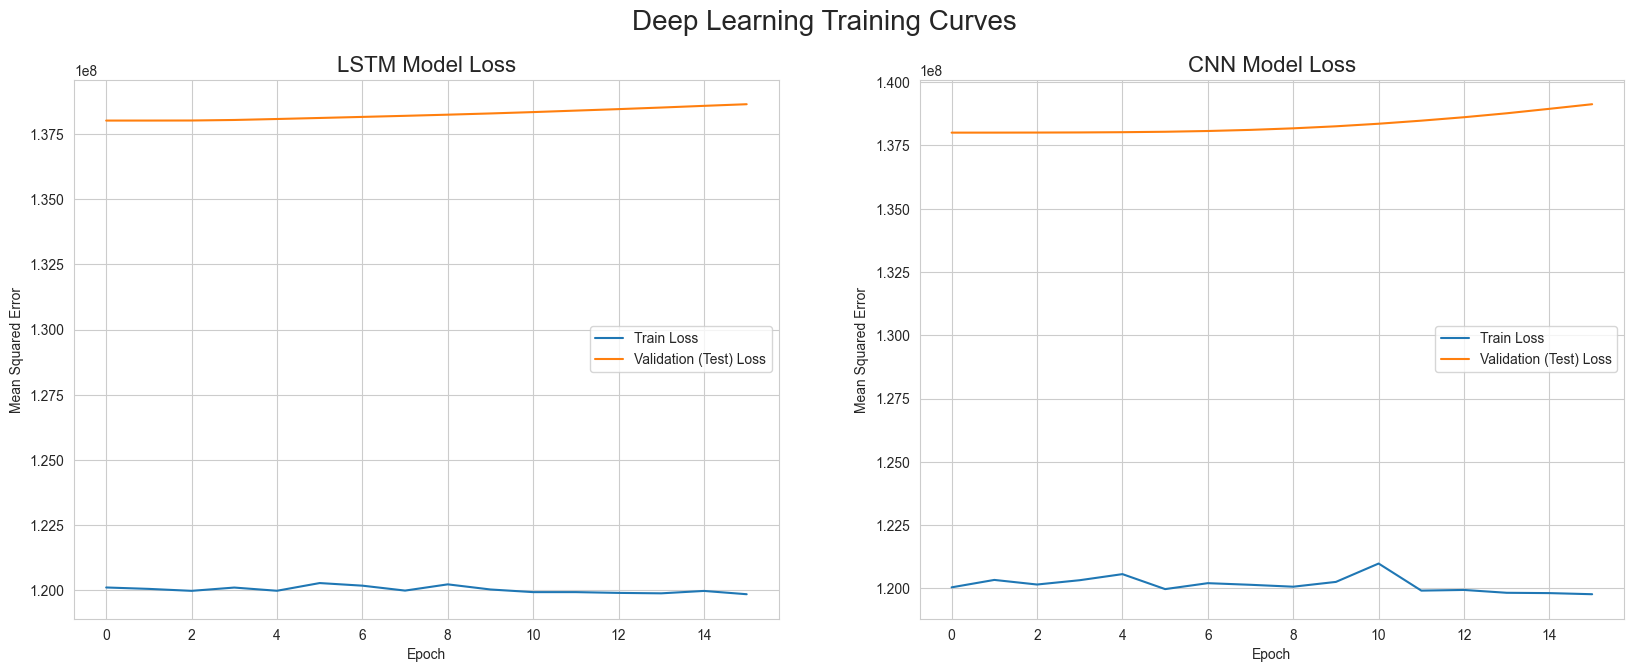

In [ ]:
if RUN_MODELS['LSTM'] and RUN_MODELS['CNN']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    ax1.plot(train_losses_lstm, label='Train Loss')
    ax1.plot(val_losses_lstm, label='Validation (Test) Loss')
    ax1.set_title('LSTM Model Loss', fontsize=16)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Squared Error')
    ax1.legend()
    ax2.plot(train_losses_cnn, label='Train Loss')
    ax2.plot(val_losses_cnn, label='Validation (Test) Loss')
    ax2.set_title('CNN Model Loss', fontsize=16)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Squared Error')
    ax2.legend()
    plt.suptitle('Deep Learning Training Curves', fontsize=20)
    plt.savefig("loss_curves.png")
    plt.show()

## 10. Final Evaluation

In [ ]:
# Align test sets
matched_test_df = pd.concat([group.iloc[LOOKBACK-1:] for _, group in test_df_dl.groupby(CAT_COLS) if len(group) >= LOOKBACK])
matched_test_ml_df = pd.concat([group.iloc[LOOKBACK-1:] for _, group in test_df.groupby(CAT_COLS) if len(group) >= LOOKBACK])
X_test_ml_matched = matched_test_ml_df[ML_FEATS]
X_test_dl_matched, y_test_det_matched = create_sequences(matched_test_df, 1, DL_FEATS, TARGET_DET)
y_test_det_matched = y_test_det_matched.flatten()
trend_test = matched_test_df['yield_trend'].values
y_true_original = matched_test_df[TARGET].values

# Predictions
test_preds = {}
for name in models:
    if name in ['LR', 'RF', 'XGB']:
        test_preds[name] = models[name].predict(X_test_ml_matched)
    elif name in ['LSTM', 'CNN']:
        X_test_dl_inputs_m = split_dl(X_test_seq)
        models[name].eval()
        with torch.no_grad():
            test_preds[name] = models[name](*[x.to(device) for x in X_test_dl_inputs_m]).cpu().numpy().flatten()

# Evaluate
results = []
y_preds_original = {}
for name, pred_det in test_preds.items():
    pred_orig = pred_det + trend_test
    y_preds_original[name] = pred_orig
    mae = mean_absolute_error(y_true_original, pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_original, pred_orig))
    map_e = mape(y_true_original, pred_orig)
    rms_pe = rmspe(y_true_original, pred_orig)
    r_2 = r2_score(y_true_original, pred_orig)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': map_e, 'RMSPE (%)': rms_pe, 'R²': r_2})

results_df = pd.DataFrame(results).set_index('Model').sort_values('RMSPE (%)')
print("\n--- Final Performance (Test Set) ---")
print(results_df.round(2))
results_df.to_csv("final_model_performance.csv")


--- Final Performance (Test Set) ---
           MAE      RMSE  MAPE (%)  RMSPE (%)    R²
Model                                              
RF     2194.68   6675.33      2.78       7.98  1.00
LR     2782.77   6692.38      3.47       8.50  1.00
XGB    3711.91   8202.02      4.76      11.09  0.99
CNN    6219.10  11795.40      7.73      17.06  0.99
LSTM   6182.75  11774.33      7.65      17.19  0.99


## 11. Plot Model Performances

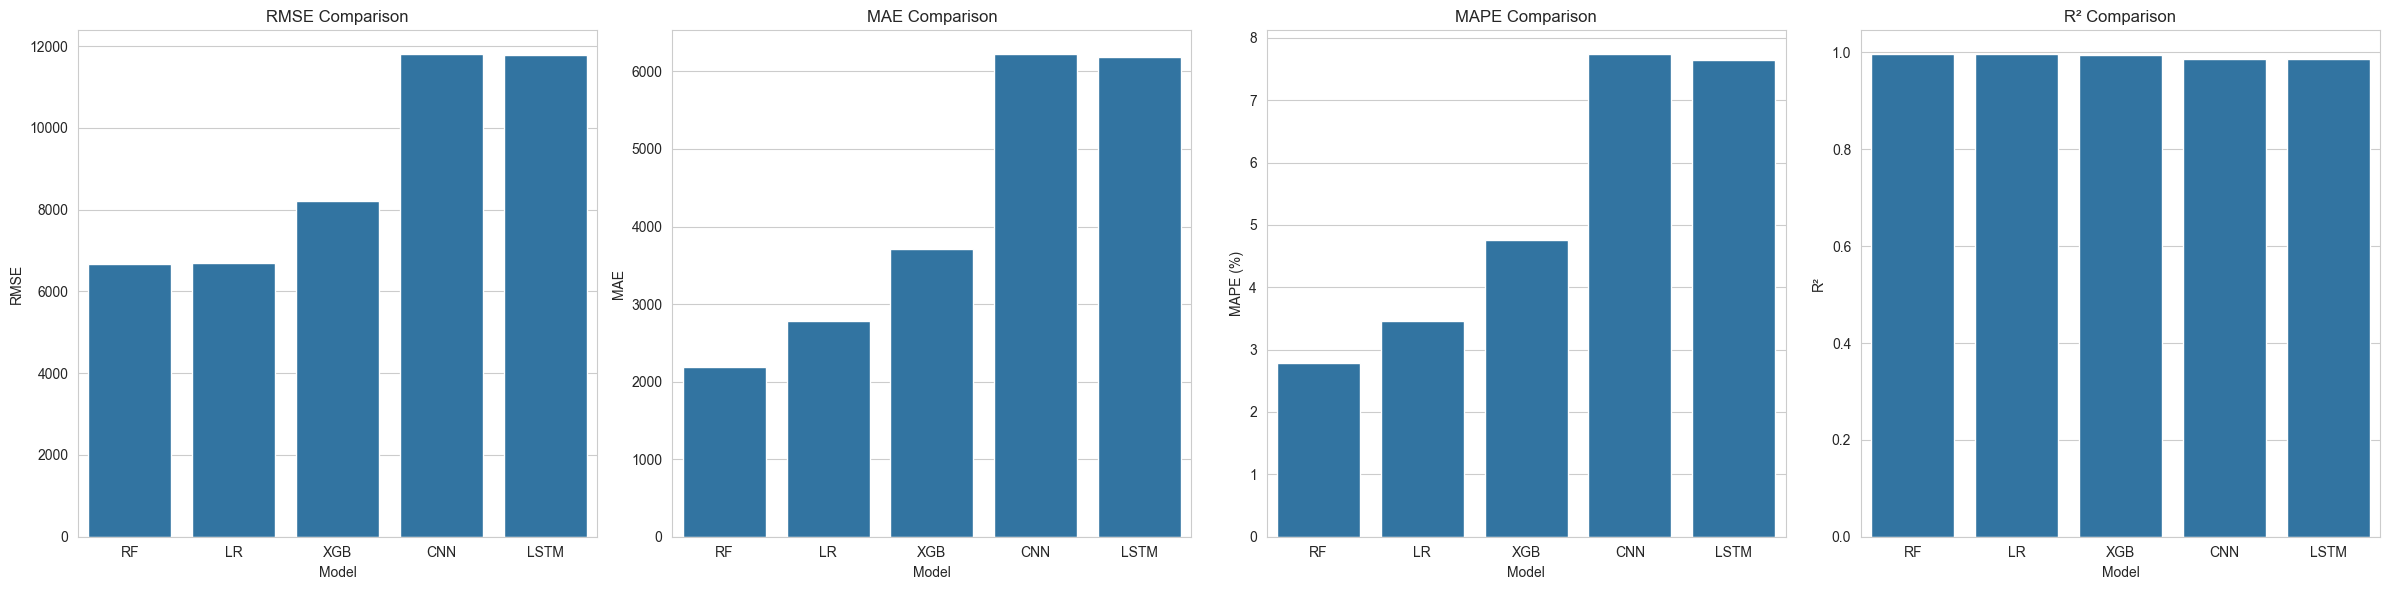

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
sns.barplot(data=results_df.reset_index(), x='Model', y='RMSE', ax=axs[0])
axs[0].set_title('RMSE Comparison')
sns.barplot(x='Model', y='MAE', data=results_df.reset_index(), ax=axs[1])
axs[1].set_title('MAE Comparison')
sns.barplot(x='Model', y='MAPE (%)', data=results_df.reset_index(), ax=axs[2])
axs[2].set_title('MAPE Comparison')
sns.barplot(x='Model', y='R²', data=results_df.reset_index(), ax=axs[3])
axs[3].set_title('R² Comparison')
plt.tight_layout()
plt.savefig("model_performance_comparison.png")
plt.show()

## 12. Per-Crop Reporting (Best Model)

In [ ]:
best_model_name = results_df.index[0]
print(f"Per-crop report for best model: {best_model_name}")
crop_results = []
items = matched_test_df['Item'].values
for crop in np.unique(items):
    mask = items == crop
    true = y_true_original[mask]
    pred = y_preds_original[best_model_name][mask]
    crop_results.append({
        'Crop': crop,
        'RMSPE (%)': rmspe(true, pred),
        'MAPE (%)': mape(true, pred),
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'R²': r2_score(true, pred)
    })
crop_df = pd.DataFrame(crop_results).sort_values('RMSPE (%)')
print(crop_df.round(2))
crop_df.to_csv('per_crop_performance.csv', index=False)

Per-crop report for best model: RF
                   Crop  RMSPE (%)  MAPE (%)      RMSE    R²
9                  Yams       1.25      0.76   1700.97  1.00
4           Rice, paddy       3.33      1.54   2023.78  0.99
1                 Maize       3.95      2.08   2181.81  0.99
7        Sweet potatoes       4.01      2.29   6567.05  0.99
3              Potatoes       4.98      2.29  14600.11  0.96
6              Soybeans       5.02      3.22    956.86  0.99
8                 Wheat       5.56      2.83   1988.19  0.98
0               Cassava       7.31      2.50   5966.42  1.00
2  Plantains and others      12.43     10.40  17804.20  0.91
5               Sorghum      19.80      5.94   4923.39  0.91


## 13. SHAP Analysis (If Tree Model)

Running SHAP on RF


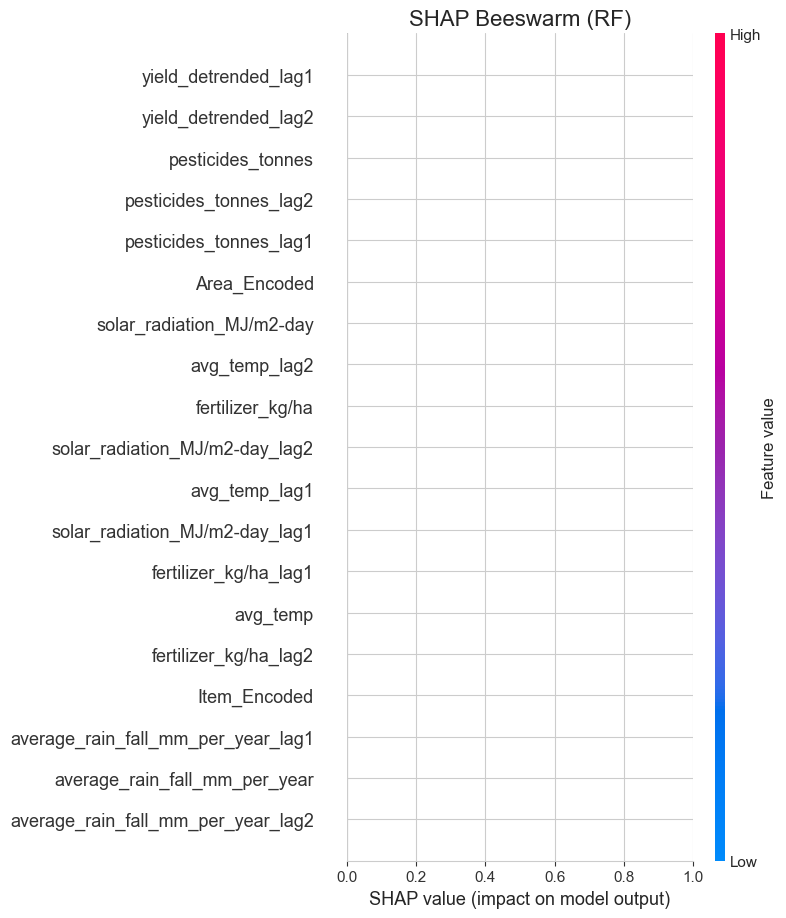

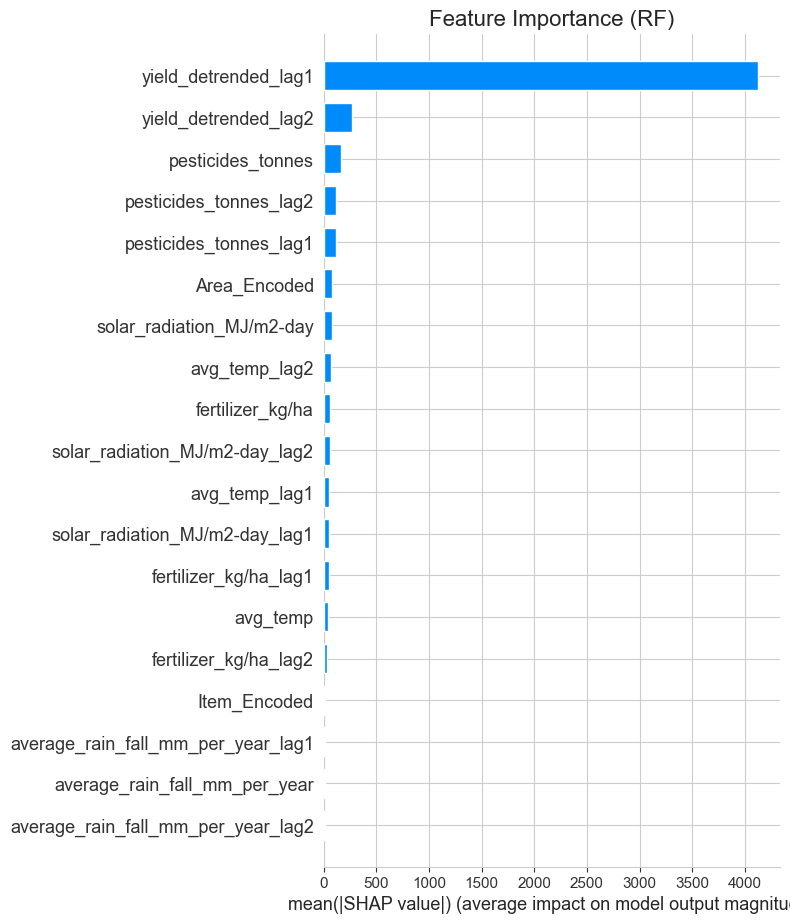

In [ ]:
best_model_name = results_df.index[0]
if best_model_name in models and best_model_name in ['RF', 'XGB']:
    best_model = models[best_model_name]
    print(f"Running SHAP on {best_model_name}")
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_ml_matched)
    shap.summary_plot(shap_values, X_test_ml_matched, plot_type="beeswarm", show=False)
    plt.title(f"SHAP Beeswarm ({best_model_name})", fontsize=16)
    plt.savefig("shap_beeswarm.png", bbox_inches='tight')
    plt.show()
    shap.summary_plot(shap_values, X_test_ml_matched, plot_type="bar", show=False)
    plt.title(f"Feature Importance ({best_model_name})", fontsize=16)
    plt.savefig("shap_importance.png", bbox_inches='tight')
    plt.show()
else:
    print("SHAP skipped for non-tree model.")

## 14. Export Predictions

In [ ]:
final_predictions_df = matched_test_df.copy()
final_predictions_df['true_yield_original'] = y_true_original
for name in test_preds:
    final_predictions_df[f'predicted_{name}'] = y_preds_original[name]
export_cols = ['Year', 'Area', 'Item', 'true_yield_original'] + [f'predicted_{name}' for name in test_preds]
final_predictions_df[export_cols].to_csv("final_test_predictions.csv", index=False)
print("Exported predictions.")
print("\n--- Complete ---")

Exported predictions.

--- Complete ---
